<h1 style="text-align:Left; font-size: 30px; font-weight: bold;"> SHAP values and times series</h1>

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Issue</h2>

A lot of questions were asked about how to use SHAP values with models that have a 2d input (like LSTM and GRU) in a context of time series.  

I did not found any paper proving that dynamic components of a dynamic systems could be modelized by a neural network or XGBoost. I did not search a lot, since I was curious and I wanted to learn to modelize dynamic system in Python. So,  a paper about that probably exists but I did not find it.

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Objectives</h2>

The first objective will be to modelize a dynamic system with XGBoost and then analyze it with SHAP values.

The second objective will be to modelize the same system with a neural network with a 2D input  and see if we can get the same results as the previous objective. 


<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Protocol and scope</h2>


The first objective will be to modelize a dynamic system with XGBoost and then analyze it with SHAP values.

The second objective will be to modelize the same system with a neural network with a 2D system and see if we can get the same results as the previous objective. 


<p style=" font-size: 24px; font-weight: bold;"> Configuration and Library Imports</p>


In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os

import random


from IPython.display import display


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.subplots import make_subplots


import math


import matplotlib.pyplot as plt # plots

import control as ct # control systems librar

#pour calculer le temps de calcul
import time

#pour diviser le dataset
from sklearn.model_selection import train_test_split

#POur XGBoost
import xgboost as xgb

#Pour la recherche aléatoire
from sklearn.model_selection import RandomizedSearchCV

#POur les Stats

from scipy import stats as st

from sklearn.metrics import r2_score

import shap
shap.initjs()

import tensorflow as tf

# VERY IMPORTNAT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
tf.compat.v1.disable_v2_behavior()

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import optimizers


from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import callbacks

Instructions for updating:
non-resource variables are not supported in the long term


<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Systems</h2>

The system will be composed of the sum of 2 systems.

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> System 1</h2>

Input = U1
Gain = 1
Time constant = 0.5
Delay = 3

![alt text](system_1.png "Title")

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> System 2</h2>

Input = U2
Gain = 1
Time constant = 1
Delay = 0

![alt text](system_2.png "Title")

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Step response on U1 and U2 at t=0 of the system</h2>

![alt text](system_1+2.png "Title")

It is important that both systems have the same gain. Otherwise, it would be more difficult to compare the SHAP values related to U1 and U2.  

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Input of the system</h2>

So the input (U1 and U2) will look like this (for 1000 points). For the details, you can look at the code. I am satisfied of it since it looks like industrial signals with long stable periods and very active periods. 

![alt text](input.png "Title")
The input for the model will be :

for U1 : U1 (at t= t ), U1m1 (at t= t - 0.5), U1m2 (at t= t - 1.0), U1m3 (at t= t - 1.5),..., U1m12 (at t= t - 6.0)

for U2 : U2 (at t= t ), U2m1 (at t= t - 0.5), U2m2 (at t= t - 1.0), U2m3 (at t= t - 1.5),..., U2m12 (at t= t - 6.0)

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;">  Correlation matrix of the input of the system</h2>

This a part of the correlation matrix of the imput (you can see the whole matrix in the program). It does make sense since the probability that U at t+1 is different of U at t is around 0.1.

![alt text](correlation.png "Title")

<p style=" font-size: 24px; font-weight: bold;"> Code for creating the random input</p>

C:\Users\bertr\AppData\Local\Temp\ipykernel_13392\117994416.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df= df.ffill()


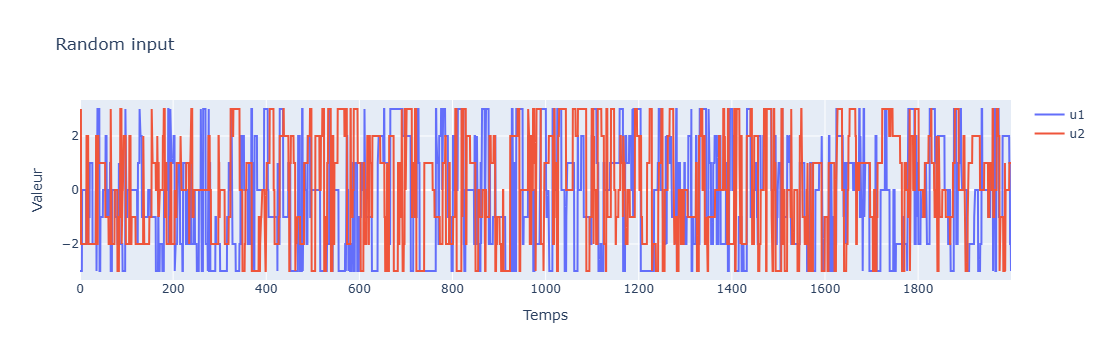

In [2]:

#Création du vecteur indexe
Temps_final = 2000
Temps_initial = 0
simulation_dt = 0.5

Vecteur =  np.arange(Temps_initial, Temps_final,simulation_dt)


#Création du Dataframe
df = pd.DataFrame(data=None , index=Vecteur, columns=['x', 'u1', 'u2'])
df.index.name = 'Temps'

#Création du random input
df["rand_1"] = np.random.randint(low=-3, high=4, size=len(df))
df["test_1"] = np.random.uniform(size=len(df))
df.loc[df["test_1"] < 0.12, "u1"] = df["rand_1"].copy()
df.loc[0,"u1"] = df.loc[0,"rand_1"]

df["rand_2"] = np.random.randint(low=-3, high=4, size=len(df))
df["test_2"] = np.random.uniform(size=len(df))
df.loc[df["test_2"] < 0.12, "u2"] = df["rand_2"].copy()
df.loc[0,"u2"] = df.loc[0,"rand_2"]

df= df.ffill()

#Graph du random input
fig = make_subplots(specs=[[{"secondary_y": False}]])

 
fig.add_trace(
    go.Scatter(x=df.index.values,
               y=df["u1"], 
               name="u1"
              ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index.values,
               y=df["u2"], 
               name="u2"
              ),
    secondary_y=False,
)


titre = " Random input " 
fig.update_layout(
    title_text=titre
)
# Set x-axis title
fig.update_xaxes(title_text="Temps")

# Set y-axes titles
fig.update_yaxes(title_text="Valeur", secondary_y=False)
#fig.update_yaxes(title_text="fe", secondary_y=True)
fig.show()


<p style=" font-size: 24px; font-weight: bold;"> Code for creating the system (no correlation matrix)</p>

ValueError: x and y must have same first dimension, but have shapes (1,) and (16,)

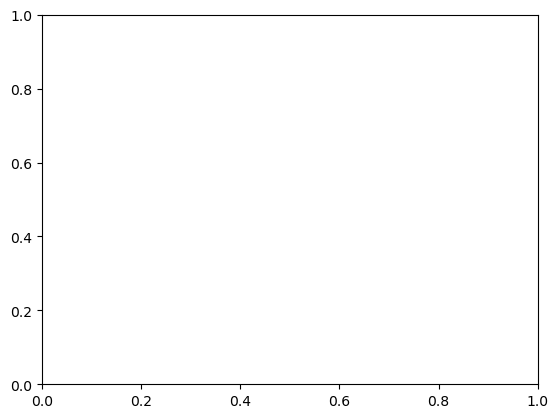

In [5]:
delayer = time_delay_system(3, simulation_dt, inputs='y', outputs='y1')
t, y  = ct.input_output_response(delayer, time_delay, step_input)
plt.figure()
plt.plot(time, step_input, 'r.-', label='input')
plt.plot(t, y, '.-', label='output')
plt.legend()

matrix for the diferential model
       indice        u1      u1-1       du1        u2      u2-1       du2
Temps                                                                    
0.0         0  0.000000       NaN       NaN  0.000000       NaN       NaN
0.5         1  0.000000  0.000000  0.000000  0.393469  0.000000  0.393469
1.0         2  0.000000  0.000000  0.000000  0.632121  0.393469  0.238651
1.5         3  0.000000  0.000000  0.000000  0.776870  0.632121  0.144749
2.0         4  0.000000  0.000000  0.000000  0.864665  0.776870  0.087795
2.5         5  0.000000  0.000000  0.000000  0.917915  0.864665  0.053250
3.0         6  0.000000  0.000000  0.000000  0.950213  0.917915  0.032298
3.5         7  0.632121  0.000000  0.632121  0.969803  0.950213  0.019590
4.0         8  0.864665  0.632121  0.232544  0.981684  0.969803  0.011882
4.5         9  0.950213  0.864665  0.085548  0.988891  0.981684  0.007207
5.0        10  0.981684  0.950213  0.031471  0.993262  0.988891  0.004371
5.5  

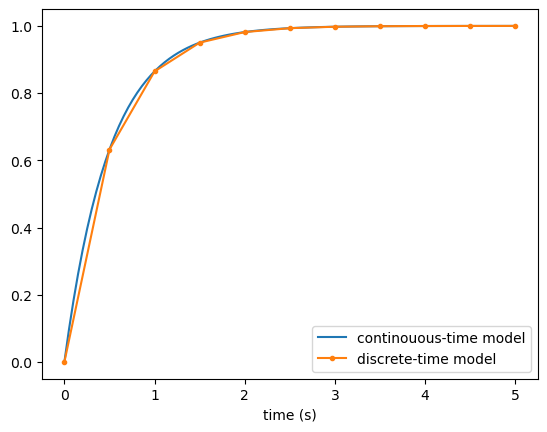

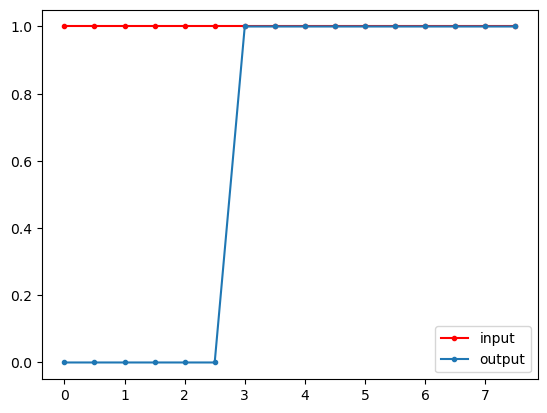

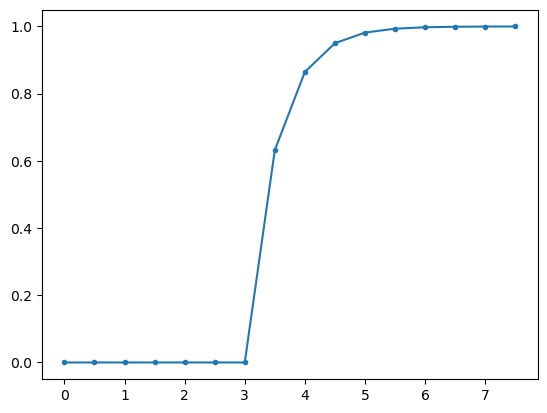

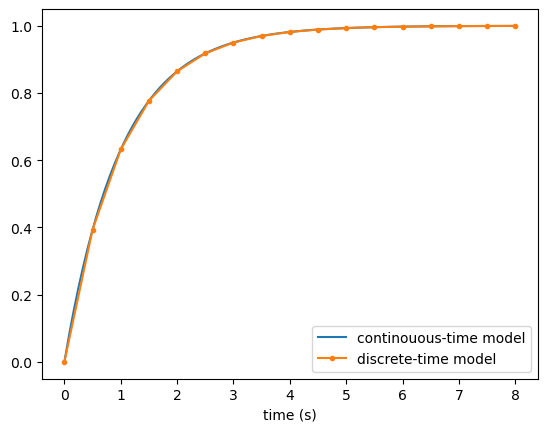

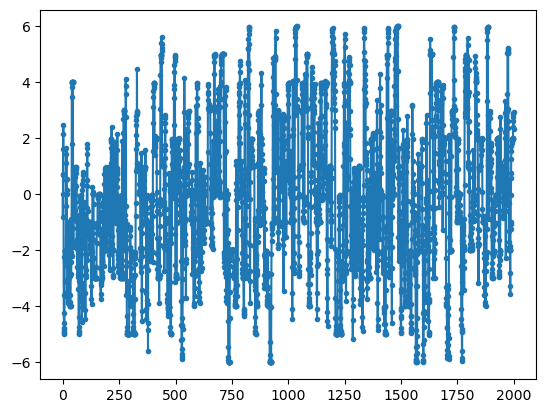

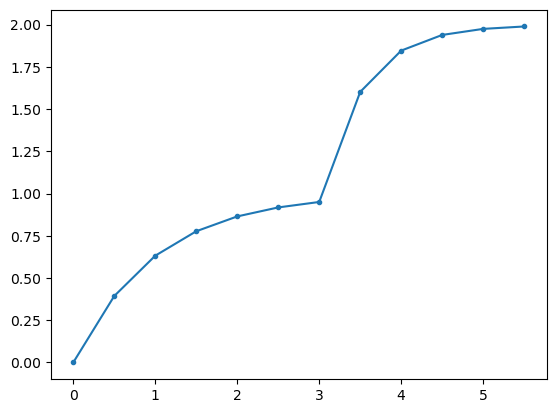

In [10]:

#Création de l'array pour utliser ct

step_input_sys = np.transpose(df[["u1", "u2"]].to_numpy())
# for  continuous-time plant model (tau =0.5 gain =1 dealy =3)


# Création du système sans retard,  continuous-time plant model (tau =0.5 gain =1 dealy =0)
plantcont = ct.tf(1, (0.5, 1), inputs='u1', outputs='y')
t, y = ct.step_response(plantcont, 5)

plt.figure()
plt.plot(t, y, label='continouous-time model')

# create discrete-time simulation form assuming a zero-order hold
#simulation_dt = 0.5 # time step for numerical simulation ("numerical integration")
plant_simulator = ct.c2d(plantcont, simulation_dt, 'zoh')


t, y = ct.step_response(plant_simulator, 5)
plt.plot(t, y, '.-', label='discrete-time model')
plt.legend()
plt.xlabel('time (s)');


# pour le retard
time_delay = np.arange(0, 8, simulation_dt)
step_input = np.ones_like(time_delay)

def time_delay_system(delay, dt, inputs=1, outputs=1, **kwargs):
    """
    creates a pure time delay discrete-time system.
    time delay is equal to nearest whole number of `dt`s."""
    assert delay >= 0, "delay must be greater than or equal to zero"
    n = int(round(delay/dt))
    ninputs = inputs if isinstance(inputs, (int, float)) else len(inputs)
    assert ninputs == 1, "only one input supported"
    A = np.eye(n, k=-1)
    B = np.eye(n, 1)
    C = np.eye(1, n, k=n-1)
    D = np.zeros((1,1))
    return ct.ss(A, B, C, D, dt, inputs=inputs, outputs=outputs, **kwargs)

delayer = time_delay_system(3, simulation_dt, inputs='y', outputs='y1')
t, y  = ct.input_output_response(delayer, time_delay, step_input)
plt.figure()
plt.plot(time_delay, step_input, 'r.-', label='input')
plt.plot(t, y, '.-', label='output')
plt.legend()
#delayer

# incorporate delay into system by relabeling plant input signal
#plant_simulator = ct.ss(plant_simulator, inputs='ud', outputs='y')

# system from r to y
Gyr_simulator = ct.interconnect([ plant_simulator,  delayer],
                                inputs='u1', outputs='y1')

# simulate
t, y = ct.input_output_response(Gyr_simulator, time_delay, step_input)
plt.figure()
plt.plot(t, y, '.-');

#For the matrix to show the diffenrial modekl
#POur la matrice du modèle différentiel

df_1er = pd.DataFrame(data=None , index=t, columns=["indice",'u1', 'u1-1',"du1", 'u2',"u2-1", "du2",])
df_1er.index.name = 'Temps'

df_1er['u1']=y
df_1er['indice'] = np.arange(0, y.shape[0])

#For the U2 model, tau = 1 gain =1 delay =0 

# continuous-time plant model
plantcont2 = ct.tf(1, (1, 1), inputs='u2', outputs='y2')
t, y2 = ct.step_response(plantcont2, 8)

plt.figure()
plt.plot(t, y2, label='continouous-time model')

# create discrete-time simulation form assuming a zero-order hold
#simulation_dt = 0.02 # time step for numerical simulation ("numerical integration")
plant_simulator2 = ct.c2d(plantcont2, simulation_dt, 'zoh')

t, y2 = ct.step_response(plant_simulator2, 8)
plt.plot(t, y2, '.-', label='discrete-time model')
plt.legend()
plt.xlabel('time (s)');

#Still for the differential model
df_1er["u2"]= y2[:-1]

df_1er["u1-1"] = df_1er["u1"].shift(periods=1)
df_1er["u2-1"] = df_1er["u2"].shift(periods=1)

df_1er["du1"] = df_1er["u1"]- df_1er["u1-1"]
df_1er["du2"] = df_1er["u2"]- df_1er["u2-1"]

print("matrix for the diferential model")
print(df_1er)

# Sommation de U1 et u2
sumblk = ct.summing_junction(inputs=['y1', 'y2'], output='yt')
T = ct.interconnect([Gyr_simulator, plant_simulator2, sumblk], inplist=['u1', 'u2'], outlist='yt')


#Simulation du modèle U1+u2

time_sim= np.arange(Temps_initial, Temps_final, simulation_dt)

t, y = ct.input_output_response(T, time_sim, step_input_sys)

plt.figure()
plt.plot(t, y.reshape(t.shape), '.-');


# unitary step on U1 and U2 at t=0
temps_exemple = np.arange(0, 6, simulation_dt)
input_exemple = np.full((2,temps_exemple.shape[0] ), 1)

t_exemple, y_exemple = ct.input_output_response(T, temps_exemple, input_exemple)


plt.figure()
plt.plot(t_exemple, y_exemple.reshape(t_exemple.shape), '.-');

#  data to modelize into the matrix
df["x"]= np.transpose(y)

# data for the previuos rows

df["u1m1"] = df["u1"].shift(periods=1)
df["u1m2"] = df["u1"].shift(periods=2)
df["u1m3"] = df["u1"].shift(periods=3)
df["u1m4"] = df["u1"].shift(periods=4)
df["u1m5"] = df["u1"].shift(periods=5)
df["u1m6"] = df["u1"].shift(periods=6)
df["u1m7"] = df["u1"].shift(periods=7)
df["u1m8"] = df["u1"].shift(periods=8)
df["u1m9"] = df["u1"].shift(periods=9)
df["u1m10"] = df["u1"].shift(periods=10)
df["u1m11"] = df["u1"].shift(periods=11)
df["u1m12"] = df["u1"].shift(periods=12)

df["u2m1"] = df["u2"].shift(periods=1)
df["u2m2"] = df["u2"].shift(periods=2)
df["u2m3"] = df["u2"].shift(periods=3)
df["u2m4"] = df["u2"].shift(periods=4)
df["u2m5"] = df["u2"].shift(periods=5)
df["u2m6"] = df["u2"].shift(periods=6)
df["u2m7"] = df["u2"].shift(periods=7)
df["u2m8"] = df["u2"].shift(periods=8)
df["u2m9"] = df["u2"].shift(periods=9)
df["u2m10"] = df["u2"].shift(periods=10)
df["u2m11"] = df["u2"].shift(periods=11)
df["u2m12"] = df["u2"].shift(periods=12)




<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Modelization of the system</h2>

The system was modelized with the input previously mentionned. XGBoost was used. You can look in the code for more details. Since the model is not saved, the parameter might change. This is the performance of the model on data that was not used in the training nor the validation. 

![alt text](XGB_perf.png "Title")

The R2 was 0.995, which is suspicious. But, the system is very simple, the reponse is quite fast and most of the 13 timestpes  are 0 or 1. The system is linear and there is no measurement noise. So, it could be possible that the model can predict perfectly the system. Any signs of overfit will be seen in the SHAP value analysis.  

<p style=" font-size: 24px; font-weight: bold;"> Code for modelizing the system with correlation matrix</p>

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
Runtime of the program is 100.15862083435059
[0]	validation_0-rmse:2.31618
[1]	validation_0-rmse:2.17237
[2]	validation_0-rmse:2.03173
[3]	validation_0-rmse:1.91327
[4]	validation_0-rmse:1.81141
[5]	validation_0-rmse:1.70909
[6]	validation_0-rmse:1.62001
[7]	validation_0-rmse:1.53122
[8]	validation_0-rmse:1.45889
[9]	validation_0-rmse:1.37596
[10]	validation_0-rmse:1.30498
[11]	validation_0-rmse:1.24313
[12]	validation_0-rmse:1.19044
[13]	validation_0-rmse:1.13685
[14]	validation_0-rmse:1.08079
[15]	validation_0-rmse:1.03035
[16]	validation_0-rmse:0.98651
[17]	validation_0-rmse:0.94583
[18]	validation_0-rmse:0.90998
[19]	validation_0-rmse:0.87021
[20]	validation_0-rmse:0.83307
[21]	validation_0-rmse:0.79805
[22]	validation_0-rmse:0.76909
[23]	validation_0-rmse:0.73817
[24]	validation_0-rmse:0.70971
[25]	validation_0-rmse:0.67996
[26]	validation_0-rmse:0.65675
[27]	validation_0-rmse:0.63021
[28]	validation_0-rmse:0.60784
[

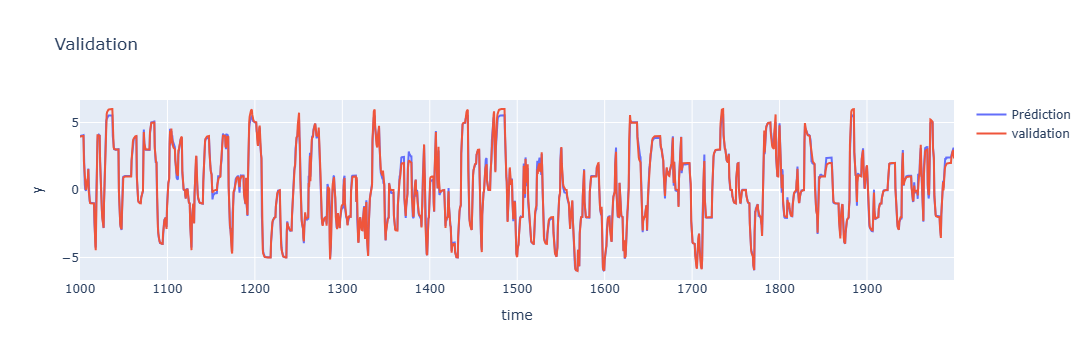

In [11]:

#copie des données pour protection
data = df.copy()

#mise en page des données
data.dropna(inplace = True)

# création de l'ensemble test (validation) et d'entraînement

data_val = data.loc[1000:].copy()
data =  data.loc[:999.5].copy()

#Creation of the data for the model
target = data['x'].copy()
target_val =  data_val['x'].copy()

data.drop(columns=['x', 'rand_1',"rand_2","test_1", "test_2"],inplace = True )
data_val.drop(columns=['x', 'rand_1',"rand_2","test_1", "test_2"],inplace = True )

#Code for the correlation matrix

corre = data.corr(method='spearman')


corre.style.background_gradient(cmap='coolwarm').format(precision=2)
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

#Division du dataset
train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)

#Création du modèle et paramétrisation aléatoire
#'tree_method': 'gpu_hist'
params={'random_state': 42}
model = xgb.XGBRegressor(**params)

param_grid = {
        'lambda':st.uniform(22, 130) 
        ,
        'alpha': st.uniform(1.25, 6.5)
        ,
        'colsample_bytree': st.uniform(0.70, 0.3)
        ,
        'subsample': st.beta(10, 1)
        ,
        'learning_rate': st.uniform(0.06, 0.06)
        ,
        'n_estimators':  st.randint(50, 250)
        ,
        'max_depth':  st.randint(2, 7)
        ,
        'min_child_weight': st.randint(30, 150)
    }
#clf = RandomizedSearchCV(model, param_distributions = param_grid, n_iter = 4, scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)
clf = RandomizedSearchCV(model, param_distributions = param_grid, n_iter =1500, verbose = 3,n_jobs=10)

#del time

# I should not do that but I am bad at programming if you have not already noticed it 
import time

start = time.time()





clf.fit(train_x,train_y)

end = time.time()

print(f"Runtime of the program is {end - start}")

clf.best_estimator_.get_params()



start = time.time()


#model = xgb.XGBRegressor(**study.best_trial.params)
model = clf.best_estimator_
model.fit(train_x,train_y,eval_set=[(test_x,test_y)],verbose=True)

end = time.time()

print(f"Runtime of the program is {end - start}")

#R2 du modèle

preds = model.predict(data_val)
r2 = r2_score(target_val, preds)
print("R2 est") 
print(r2) 

#print (len(preds),len(test_y))
#test_y.head()
#g1=[0]

dataval = {'Prédiction':  preds, 
        'Validation': target_val
        }

g1 = pd.DataFrame (dataval, columns = ['Prédiction','Validation'])

#g1['prédiction']=preds
#g1['valisation']=test_y[:2]
g1.sort_index(inplace=True)

#Figure for the validation

fig = make_subplots(specs=[[{"secondary_y": False}]])

 #Add traces


fig.add_trace(
    go.Scatter(x=g1.index.values,
               y=g1["Prédiction"], 
               name="Prédiction"

              ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=g1.index.values,
               y=g1["Validation"], 
               name="validation"

              ),
    secondary_y=False,
)

#].interpolate().rolling(v_temps).mean()





titre = " Validation " 
fig.update_layout(
    title_text=titre
)
# Set x-axis title
fig.update_xaxes(title_text="time")

# Set y-axes titles
fig.update_yaxes(title_text="y", secondary_y=False)
#fig.update_yaxes(title_text="fe", secondary_y=True)
fig.show()


<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> SHAP values analysis of the XGBoost model</h2>

There were no problem with the calculation of the SHAP values. As for the SHAP value they don't show any signs of overfit in the sense that the most important variables are the ones that are expected.

In other words, we expect that every values below ( and including ) the delay should be very low. For U1, these variables are U1 (t=0), U1m1 (t=0.5) to U1m6 (t=3). For U2, the only value is U2. Also, the values at the end of the response of the step should have less importance. If you look too far into the past, it does not means anything, like using the temperature 10 years ago to predict the temperature in the five next minutes. So we would expect that the later value to have low SHAP values. Also, the SHAP values are the highest for U1 and U2 for the expected time steps, the first step after the delay, U1m7 and U2m1. So the SHAP value correctly predicted the delay for each input, 3 for U1 and 0 for U2.

![alt text](XGB_SummarySHAP.png "Title")

We the calculate the average SHAP Value. We obtain this graph:

![alt text](XGB_averageSHAP.png "Title")

Then we can compare the differential value of each step response. The first colunm (temps), is the time passed after a step reponse at t=0. Then U1 and U2 are the response of their subsystem. So the response starts at 0.5 for U2 and 3.5 for U1. Then there is a column of the value of the response  before the response( u1-1 and u2-1), that column is used to calculate the differential response. The differential response is the jump that was made for each time steps for each response(0.69 for U1m7, 0.39 for U2m1, .....). It is interesting to see that the order of the average SHAP value is almost the same order of the imporance of each differential response. It opens the possibility of obtaining a differential model with the SHAP values.

![alt text](XGB_table.png "Title")

Finally, the graph of the SHAP value for some variables are created. They are linear, it is logic since the system is linear. What is surprising is that even if the R2 is near perfect, there is some variability of the SHAP value at eache value of a variable, almost 0.25 at certain value. I would have expected no variability.

![alt text](XGB_SHAP1.png "Title")
![alt text](XGB_SHAP2.png "Title")
![alt text](XGB_SHAP3.png "Title")
![alt text](XGB_SHAP4.png "Title")

<p style=" font-size: 24px; font-weight: bold;"> Code for the SHAP values for the XGBoost model</p>

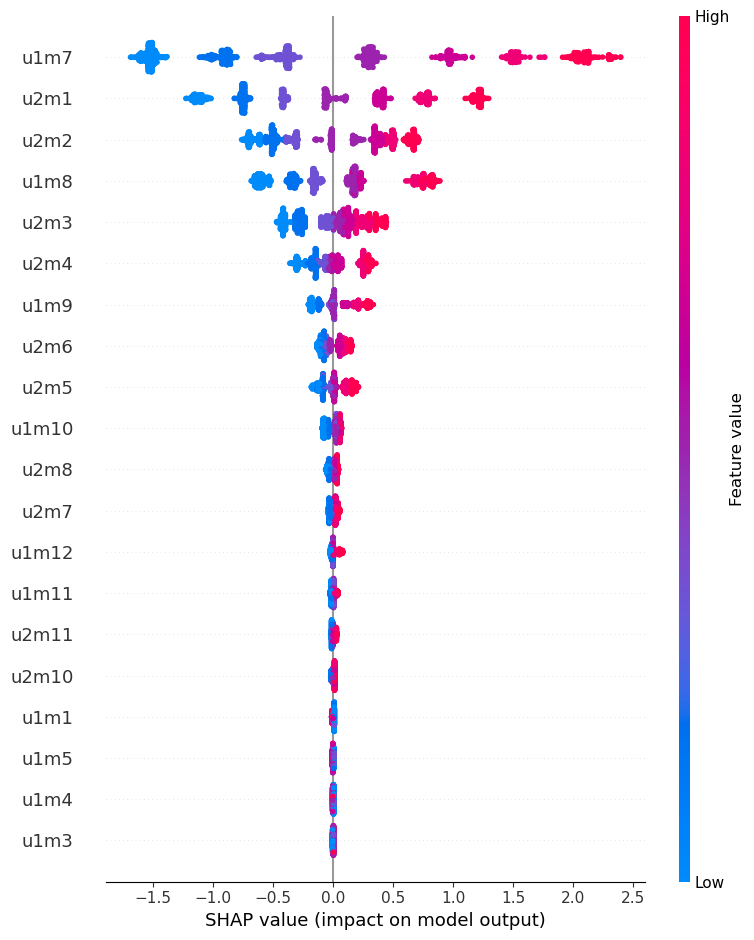

C:\Users\bertr\anaconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

C:\Users\bertr\anaconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



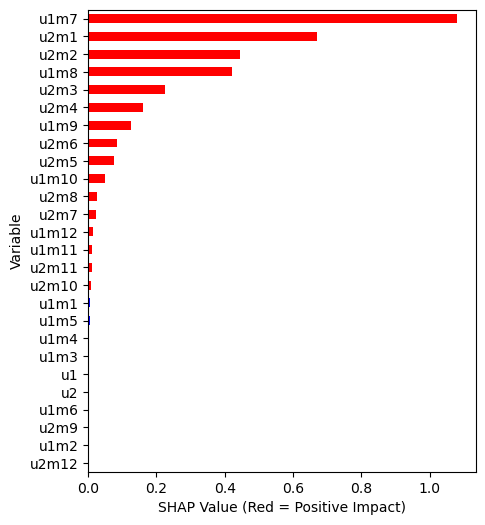

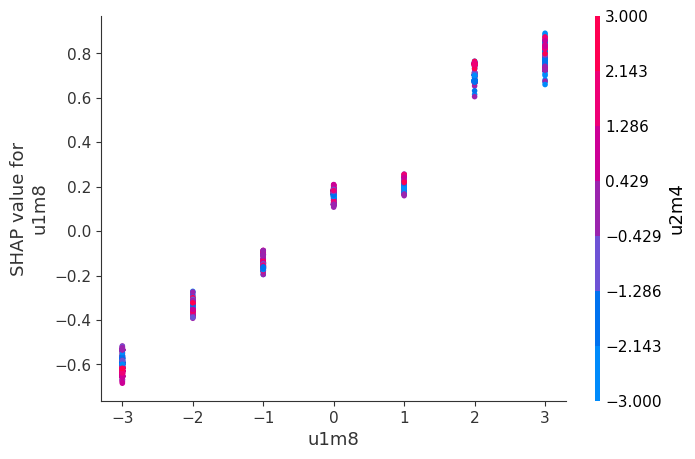

In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data)


shap.summary_plot(shap_values,  data)

#The absolute value of SHAP values

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    #df_v = df.copy().reset_index().drop('index',axis=1)
    df_v = df.copy()
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,data) 

#for each parameters. I won't list them all, just modifu the value of the variable

#shap.dependence_plot("u1m7", shap_values, data, interaction_index="t.SiO2 Fournisseur (%)")
shap.dependence_plot("u1m8", shap_values, data)

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Conclusions of the SHAP values analysis of the XGBoost model</h2>

Things to take in consideration :

- The system is the most simple that could be used, there is no measurment noise, no nonlinearities and only 2 inputs.
- The analysis of the SHAP values found the exact delay for each systems.
- The  mean value of the SHAP value approches the value of the differential model.
- There is still variability in the SHAP value even if the R2 is 0.995.

The first conclusion is that XGBoost is capable of modeling a dynamic system. It shows that for a steady-state model, is important to set an avering time for each variable so no dynamic responses will be caught.

The second conclusion is that when a model is near perfect, the SHAP value can show the delay and at leats an exproximation of the dynamics of the system.

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Future works related to the analysis of a XGBoost of a dynamic system</h2>






<h2 style="text-align:Left; font-size: 15px; font-weight: bold;">  SHAP values analysis of the a model with 2d input</h2>

In this part, we will see if we can obtian the same results but with a model with a 2d input.

The first thing to do is to make a GRU model. Secondly, we will try the get the SHAP values for the model. Finally, we will analyze them to see if they make sense. 

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Modelization of the dyanmic system by a GRU model</h2>

 This will be the input of the model, the 13th row is t=0, the 12th row is t= -0.5, the 11th row is t= -1.0,..., the first row is t= -6.0. 
![alt text](GRU_input.png "Title")


This is the structure of the model. I know is bad. But, the objective was to check if the SHAP values could be calculated.

![alt text](GRU_model.png "Title")

These are the training and validation curves.(I just did learn how to crop out the white)

![alt text](GRU_validation.png "Title")

These are the model performance on data that was not used for training nor validation. The R2 is 0.975. The performance of the model is worse than the XGBoost model. Sometime the response is too fast, sometimes a steady-state has a bias. But the main goal of this part is to get the SHAP values for this model.

![alt text](GRU_validation.png "Title")

<p style=" font-size: 24px; font-weight: bold;"> Code for modelizing the system with a GRU model</p>

Runtime of the program is 0.200852632522583
Instructions for updating:
Colocations handled automatically by placer.
Train on 1678 samples, validate on 297 samples
Epoch 1/75
1678/1678 [==============================] - ETA: 0s - loss: 1.8852

C:\Users\bertr\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



1678/1678 [==============================] - 2s 1ms/sample - loss: 1.8852 - val_loss: 3.5224
Epoch 2/75
1678/1678 [==============================] - 0s 200us/sample - loss: 1.0684 - val_loss: 3.4148
Epoch 3/75
1678/1678 [==============================] - 0s 200us/sample - loss: 0.9823 - val_loss: 3.3768
Epoch 4/75
1678/1678 [==============================] - 0s 215us/sample - loss: 0.8371 - val_loss: 3.4125
Epoch 5/75
1678/1678 [==============================] - 0s 202us/sample - loss: 0.8567 - val_loss: 3.4026
Epoch 6/75
1678/1678 [==============================] - 0s 200us/sample - loss: 0.6852 - val_loss: 3.3501
Epoch 7/75
1678/1678 [==============================] - 0s 200us/sample - loss: 0.7693 - val_loss: 3.8823
Epoch 8/75
1678/1678 [==============================] - 0s 198us/sample - loss: 0.7394 - val_loss: 3.4945
Epoch 9/75
1678/1678 [==============================] - 0s 203us/sample - loss: 0.6165 - val_loss: 3.7297
Epoch 10/75
1678/1678 [==============================] - 0s

C:\Users\bertr\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



R2
0.9765534517945464


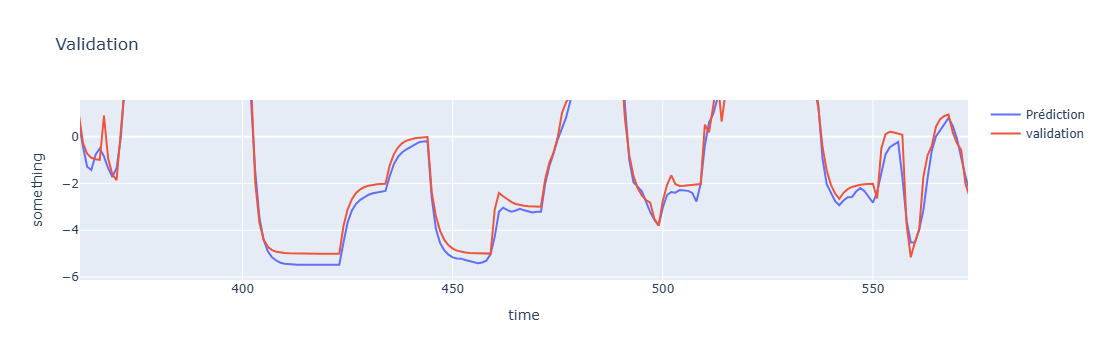

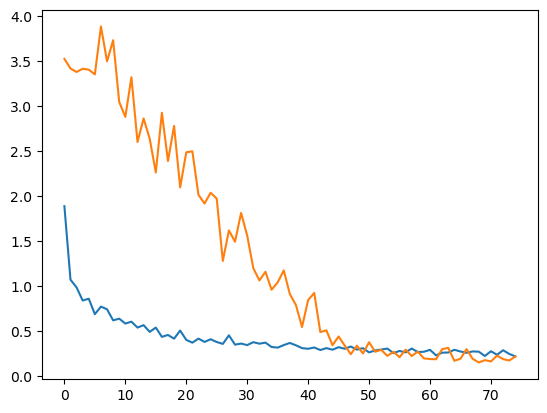

In [13]:
#Creation of the training set
datamod =data [["u1","u2"]].copy()
targetmod = target

#creation of the 2d training set

start = time.time()
Temps_en_banque = 13
    # Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
    # So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []


for i in range(Temps_en_banque,len(datamod)):
    X_train.append(datamod.iloc[i-Temps_en_banque:i,:])
    y_train.append(targetmod.iloc[i])
X_train, y_train = np.array(X_train), np.array(y_train)

end = time.time()

print(f"Runtime of the program is {end - start}")

#creation train and test sets
train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, test_size=0.15,random_state=42)

#architecture of the model

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=125, return_sequences=True, input_shape=(X_train.shape[1],2), activation='tanh'))
regressorGRU.add(Dropout(0.4))
regressorGRU.add(BatchNormalization())
# Second GRU layer
regressorGRU.add(GRU(units=62, return_sequences=True, input_shape=(X_train.shape[1],2), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(BatchNormalization())
# Fourth GRU layer
regressorGRU.add(GRU(units=20, activation='tanh'))
regressorGRU.add(Dropout(0.1))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
#regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
regressorGRU.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set

#training of the model
#24 epcoch
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 20, 
                                        restore_best_weights = True)

seqmodel =regressorGRU.fit(train_x, train_y,
          batch_size      = 250,
          epochs          = 75,
          validation_data = (test_x, test_y),
          shuffle         = True,
          callbacks=[earlystopping])
 #for visualization
 #visualizing losses and accuracy verbose=0, callbacks=[TQDMNotebookCallback()])


train_loss = seqmodel.history['loss']
val_loss   = seqmodel.history['val_loss']
#train_acc  = seqmodel.history['acc']
#val_acc    = seqmodel.history['val_acc']
xc         = range(len(seqmodel.history['loss']))

plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)

#Validation 

datamod_val =data_val [["u1","u2"]].copy()
targetmod_val = target_val

start = time.time()
Temps_en_banque = 13
    # Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
    # So for each element of training set, we have 60 previous training set elements 
X_train_val = []
y_train_val = []


for i in range(Temps_en_banque,len(datamod_val)):
    X_train_val.append(datamod_val.iloc[i-Temps_en_banque:i,:])
    y_train_val.append(targetmod_val.iloc[i])
X_train_val, y_train_val = np.array(X_train_val), np.array(y_train_val)

end = time.time()

print(f"Runtime of the program is {end - start}")

#R2 du modèle
preds = regressorGRU.predict(X_train_val)
r2 = r2_score(y_train_val, preds)

print("R2")
print(r2) 

#print (len(preds),len(test_y))
#test_y.head()
#g1=[0]

dataval = {'Prédiction':  np.squeeze(preds), 
        'Validation': y_train_val
        }

g1 = pd.DataFrame (dataval, columns = ['Prédiction','Validation'])

g1.sort_index(inplace=True)
#g1.head()

#test tc_2 #
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": False}]])

 #Add traces


fig.add_trace(
    go.Scatter(x=g1.index.values,
               y=g1["Prédiction"], 
               name="Prédiction"

              ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=g1.index.values,
               y=g1["Validation"], 
               name="validation"

              ),
    secondary_y=False,
)

#].interpolate().rolling(v_temps).mean()





titre = " Validation " 
fig.update_layout(
    title_text=titre
)
# Set x-axis title
fig.update_xaxes(title_text="time")

# Set y-axes titles
fig.update_yaxes(title_text="something", secondary_y=False)
#fig.update_yaxes(title_text="fe", secondary_y=True)
fig.show()

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;">  SHAP values calculation the a model with 2d input</h2>

To calculate the SHAP values, the line "tf.compat.v1.disable_v2_behavior()"  was added after "import tensorflow as tf". Some people were able to calculate the SHAP values without this line by using an old version of SHAP. I don't know which one. I did use the DeepExplianer module. Tee SHAP values were calculated on 297 points and it took 3 minutes. I have an old computer, so it should be faster for 95% of the wolrd population. I could not use the summary plot. And the format of the  SHAP values for the 297 point was (297, 13, 2, 1)

The code to format the SHAP value is below. Its function is to extract the SHAP values and their corresponding data for a given timeslice. If tempsdep = tempsfinal, then the slice if only one timestep. So as written, this code with only get the shap values of t = 6 , as we have seens that the 0 is for this time step and 12 is of this first.

 tempo =  np.squeeze(shap_values) 
dates = test_x 

tempsdep =  0
tempsfinal  = 0
tempsshap =  297 

m=0
Shapvalues_m od = []
Data_m od = []

i  = temp sdep
 j = 0
k = 0
for x in range(tempsshap*(tempsfinal-tempsdep + 1)):
    Shapvalues_mod.append (tempo[k,i,:])
    Data_mod.append (dates[k,i,:]) 
    i = i +  1
    j = j + 1
    if  i > tempsfinal :
         i = tempsdep 
        k = k + 1

Shapvalues_mod = np .array(Shapvalues_mod)
Data_mod = np.array(Data_mod



<h2 style="text-align:Left; font-size: 15px; font-weight: bold;">  SHAP values for t=0  with 2d input</h2>

These are the SHAP value for T=0, so U1 and U2 should not have any impact. But the SHAP values for U2 are wrong since they predict an impact.

![alt text](GRU_SHAP_t0.png "")

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;">  SHAP values for t=1  with 2d input</h2>

These are the SHAP value for T=1, so U1  should not have any impact. But the SHAP value for U1 are wrong since they predict an impact at t=0 instead of t = 3.5 since the delay. Also, the impact is gradual from t=1 instead of having a big step at t=3.5.



![alt text](GRU_SHAP_t1.png "")

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;">  SHAP values for t=2  with 2d input</h2>

These are the SHAP value for T=2, so U1  should not have any impact. But the SHAP value for U1 are wrong since they predict an impact. But U2 shows less impact and this is a good result.

![alt text](GRU_SHAP_t2.png "")

<p style=" font-size: 24px; font-weight: bold;"> Code for the SHAP values for models with 2 D inputs</p>

C:\Users\bertr\anaconda3\envs\tf\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.




Runtime of the program is 0.6668097972869873
Runtime of the program is 1065.1240577697754


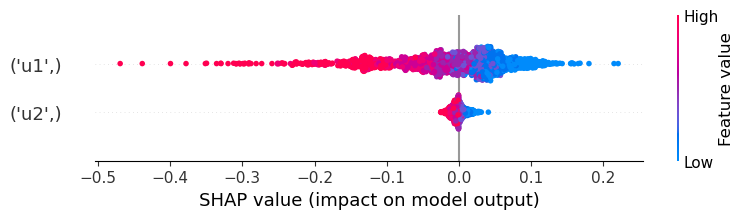

In [14]:
#max=10 *89000
start = time.time()
explainer = shap.DeepExplainer(regressorGRU, train_x)

end = time.time()
print(f"Runtime of the program is {end - start}")


start = time.time()
shap_values = explainer.shap_values(X_train_val)

end = time.time()
print(f"Runtime of the program is {end - start}")

tempo =  np.squeeze(shap_values)
dates = X_train_val


#POssibility for a slice of time, t1 = tempsdep t2=tempsfinal, for one timestep tempsdep = tempfinal. Also in this case 13 = t=0  and 0 = t=6
tempsdep = 0
tempsfinal = 0
tempsshap = X_train_val.shape[0]

m=0
Shapvalues_mod = []
Data_mod = []

i = tempsdep
j = 0
k = 0
for x in range(tempsshap*(tempsfinal-tempsdep + 1)):
    Shapvalues_mod.append(tempo[k,i,:])
    Data_mod.append(dates[k,i,:])
    i = i + 1
    j = j + 1
    if i > tempsfinal :
        i = tempsdep
        k = k + 1

Shapvalues_mod = np.array(Shapvalues_mod)
Data_mod = np.array(Data_mod)

my_list = list(datamod)

Dftest = pd.DataFrame(data = Data_mod
             , columns = [my_list])

shap.summary_plot(Shapvalues_mod, Dftest)

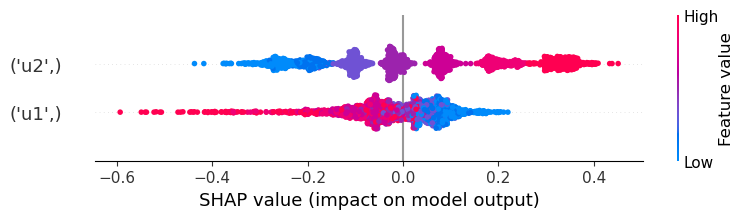

In [21]:
#This part is to use the previously claculated data 
#POssibility for a slice of time, t1 = tempsdep t2=tempsfinal, for one timestep tempsdep = tempfinal, Also in this case 13 = t=0  and 0 = t=6
tempsdep = 9
tempsfinal = 9
tempsshap = X_train_val.shape[0]

m=0
Shapvalues_mod = []
Data_mod = []

i = tempsdep
j = 0
k = 0
for x in range(tempsshap*(tempsfinal-tempsdep + 1)):
    Shapvalues_mod.append(tempo[k,i,:])
    Data_mod.append(dates[k,i,:])
    i = i + 1
    j = j + 1
    if i > tempsfinal :
        i = tempsdep
        k = k + 1

Shapvalues_mod = np.array(Shapvalues_mod)
Data_mod = np.array(Data_mod)

my_list = list(datamod)

Dftest = pd.DataFrame(data = Data_mod
             , columns = [my_list])

shap.summary_plot(Shapvalues_mod, Dftest)

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;">  Discussion</h2>

The objective was to test if there was a way to get the SHAP values with models with 2d input. It is possible, but with tensorflow,  a line of code needs ot be added. And the array of the SHAP value needs to be formated to get graphics.  Also, there are less graphical options. 



The model is not as good as the XGBoost model, but that was not the objective of this part. But it would be interesting to see what is needed to  improve the model to the equivalence of the XGBoost model.
tt
Finally, as I was doing this part, I thought about the usefullness of the 2d format. Because with multiple dynamics, the frequency would be set for the fastest input, but the lenght of the interval would be set for the slowest input. Therefore, the input would  be unecessarly big. Also, there is the possibility that the impact slowest input would be drowned by the high frequency. This hypothesis has not been tested, but in the first section, we have seen that the model will approach a differential model. Therefore, a slow response will be divided by the number of steps and the SHAP values will be diminished.

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;">  Conclusion of the second part</h2>

SHAP value can be applied to models with a 2d input, but they don't function well. Line of codes need to be added or a older version of the SHAP value program need to be used ( unverified by the author). Also, the array of the SHAP value needs to be formated to use the provided graphical interface.

More importantly, there is doubts about the usefullness of using those model for time series. The frequency is set by the fastest input and lenght of the interval is set by the slowest input. This results in the biggest input and the possibility that the SHAP value for the slowest input will be drowned. 

<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Global conclusions</h2>

A model will be influenced by the dynamical features of a process and it can be shown with the SHAP values. This means that the time window for averaging is too small for the feature X , the model with reflect the partial dynamical response of X, and its SHAP values will be lower. It also means that for the feature X, adding a second feature X but with a smaller averaging window (to catch some of th dynamical feature not cought with a larger window) could improve the performance of the model. 

Models with a 2D input (like LSTM and GRU) are not appropriate for time series. The frequency has to be set for the fastest input and the lenght has to be set for the slowest input. The result is the biggest input for the model (so more data and memory for the training phase) and a dilution of the impact of the slowest variables because the high frequency will diminish their impact (0.25 + 0.25 + 0.25 + 0.25 instead of 0.5 + 0.5 ).

SHAPS value can be calculated with model using 2D input but crutches have to be programmed.  



<h2 style="text-align:Left; font-size: 15px; font-weight: bold;"> Future works</h2>

Just by habit, I probably won't do it, unless there is some interest :

Related to dynamic systems
- Analyze the impact of sampling on the SHAP values. Is there a maximum sampling frequency, over it and the variable has no impact on the model ?
- Analyze the effect of adding a third input, measurment noise, a nonlinearity to a dynamic system. Can those results be applied to real processes ?
- Test and analyse the differential model created with the SHAP values. Can the SHAP be used to get a mathematical representation of a model ?

Related to models
- Analyze the impact of adding a new variable but with a smaller averaging time could improve the performances of a model. EX adding T° average on 15 min when there is already T° average on 60 min.

Related to models with 2d input 
- Improve the GRU model to see if the XGBoost results can be attained.  
